In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [3]:
# Bước 1: Tải dữ liệu
reviews_df = pd.read_csv('reviews_data.csv')
movies_df = pd.read_csv('movies_data.csv')

In [4]:
reviews_df.head()

Movie           Reviewer    Rating  \
0  Gladiator II          nicknocks  6.000000   
1  Gladiator II  kabirsattarshetty  6.000000   
2  Gladiator II               nb99  6.000000   
3  Gladiator II     iemand-anders1  6.580292   
4  Gladiator II     tomislavvlahek  6.000000   

                                              Review  Likes  Dislikes  \
0  There seems to be a trend these days when maki...  438.0      71.0   
1  My main issue with this film is the total lack...  593.0     115.0   
2  I tried hard not to just compare #2 with #1 wh...  554.0     109.0   
3  Now as i watched the movie i truly tried to no...  534.0      89.0   
4  I tried hard not to just compare #2 with #1 wh...  297.0      54.0   

   Sentiment_Score          Top_Keywords  
0           0.4569  action, like, better  
1          -0.5330       man, like, film  
2          -0.6072  film, bad, character  
3           0.9907    movie, story, feel  
4          -0.6072  film, bad, character

In [5]:
movies_df.head()

Title  Year  Duration   MPAA                      Genres  \
0   Gladiator II  2024  2h 28min    T18      Action,Adventure,Drama   
1        Moana 2  2024  1h 40min      P  Animation,Adventure,Comedy   
2      Gladiator  2000  2h 35min      R      Action,Adventure,Drama   
3  The Substance  2024  2h 21min      R                Drama,Horror   
4     Dear Santa  2024  1h 47min  PG-13       Comedy,Fantasy,Horror   

   IMDb_Rating              Director  \
0          6.9          Ridley Scott   
1          7.1  David G. Derrick Jr.   
2          8.5          Ridley Scott   
3          7.4       Coralie Fargeat   
4          5.3        Bobby Farrelly   

                                               Stars  \
0       Paul Mescal, Denzel Washington, Pedro Pascal   
1    Auli'i Cravalho, Dwayne Johnson, Hualalai Chung   
2     Russell Crowe, Joaquin Phoenix, Connie Nielsen   
3         Demi Moore, Margaret Qualley, Dennis Quaid   
4  Jack Black, Robert Timothy Smith, Keegan-Micha...   

                                        Plot_Summary  \
0  After his home is conquered by the tyrannical ...   
1  After receiving an unexpected call from her wa...   
2  A former Roman General sets out to exact venge...   
3  A fading celebrity takes a black-market drug: ...   
4  When a young boy mails his Christmas wish list...   

                                          Image_link  
0  https://m.media-amazon.com/images/M/MV5BM2VjZG...  
1  https://m.media-amazon.com/images/M/MV5BZDUxNT...  
2  https://m.media-amazon.com/images/M/MV5BYWQ4Ym...  
3  https://m.media-amazon.com/images/M/MV5BMTc2M2...  
4  https://m.media-amazon.com/images/M/MV5BMDNjMz...

In [6]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5296 entries, 0 to 5295
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         5296 non-null   object 
 1   Year          5296 non-null   int64  
 2   Duration      5296 non-null   object 
 3   MPAA          5296 non-null   object 
 4   Genres        5296 non-null   object 
 5   IMDb_Rating   5296 non-null   float64
 6   Director      5296 non-null   object 
 7   Stars         5296 non-null   object 
 8   Plot_Summary  5275 non-null   object 
 9   Image_link    5296 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 413.9+ KB


In [7]:
reviews_df.head()

Movie           Reviewer    Rating  \
0  Gladiator II          nicknocks  6.000000   
1  Gladiator II  kabirsattarshetty  6.000000   
2  Gladiator II               nb99  6.000000   
3  Gladiator II     iemand-anders1  6.580292   
4  Gladiator II     tomislavvlahek  6.000000   

                                              Review  Likes  Dislikes  \
0  There seems to be a trend these days when maki...  438.0      71.0   
1  My main issue with this film is the total lack...  593.0     115.0   
2  I tried hard not to just compare #2 with #1 wh...  554.0     109.0   
3  Now as i watched the movie i truly tried to no...  534.0      89.0   
4  I tried hard not to just compare #2 with #1 wh...  297.0      54.0   

   Sentiment_Score          Top_Keywords  
0           0.4569  action, like, better  
1          -0.5330       man, like, film  
2          -0.6072  film, bad, character  
3           0.9907    movie, story, feel  
4          -0.6072  film, bad, character

In [8]:
reviews_df['Reviewer'].value_counts()

Reviewer
SnoopyStyle             736
ma-cortes               457
TheLittleSongbird       451
claudio_carvalho        422
bkoganbing              274
                       ... 
samanthanelson-30846      1
tomrito                   1
stikyman123               1
penguin-65                1
happytobesam              1
Name: count, Length: 34295, dtype: int64

In [9]:
# Preprocessing
movies_df['Genres'] = movies_df['Genres'].fillna('')
movies_df['Genres'] = movies_df['Genres'].str.replace(' ', '')  # Loại bỏ khoảng trắng dư thừa

In [10]:
# Model 1: Content-Based Filtering
# -----------------------
# Create a genre profile for movies
count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
count_matrix = count_vectorizer.fit_transform(movies_df['Genres'])

# Calculate cosine similarity between movies
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# Map movie titles to indices
movie_indices = pd.Series(movies_df.index, index=movies_df['Title']).drop_duplicates()

def recommend_movies_content(user, top_n=10):
    # Get user's liked movies from reviews_df
    user_likes = reviews_df[(reviews_df['Reviewer'] == user)]['Movie']
    
    # Create user profile based on liked movies
    user_profile = np.zeros(cosine_sim.shape[0])
    for movie in user_likes:
        idx = movie_indices.get(movie, None)
        if idx is not None:
            user_profile += cosine_sim[idx]
    
    # Rank movies based on similarity to user profile
    movie_scores = list(enumerate(user_profile))
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)

    # Get top N movies
    recommended_indices = [x[0] for x in movie_scores if movies_df.iloc[x[0]]['Title'] not in user_likes][:top_n]

    # Display recommended movies with images
    displayed_count = 0
    for idx in recommended_indices:
        if displayed_count >= top_n:
            break
        title = movies_df.iloc[idx]['Title']
        poster_link = movies_df.iloc[idx]['Image_link']
        try:
            response = requests.get(poster_link, timeout=5)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
            plt.imshow(img)
            plt.axis('off')
            plt.title(title)
            plt.show()
            displayed_count += 1
        except Exception:
            print(f"Không thể tải poster cho phim: {title}. Bỏ qua.")


c:\Program Files\Python39\lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
# -----------------------
# Model 2: Collaborative Filtering (User-Based)
# -----------------------
# Filter users with at least 2 ratings
user_ratings_count = reviews_df.groupby('Reviewer')['Rating'].count()
valid_users = user_ratings_count[user_ratings_count >= 2].index
filtered_reviews_df = reviews_df[reviews_df['Reviewer'].isin(valid_users)]

# Create user-movie rating matrix
user_movie_matrix = filtered_reviews_df.pivot_table(index='Reviewer', 
                                                    columns='Movie', 
                                                    values='Rating')

# Fill missing values with 0
user_movie_matrix = user_movie_matrix.fillna(0)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

def recommend_movies_collab(user, top_n=10):
    # Get user's ratings
    user_ratings = user_movie_matrix.loc[user]
    
    # Find similar users
    similar_users = user_similarity_df[user].sort_values(ascending=False).drop(user)

    # Aggregate ratings from similar users
    weighted_scores = np.dot(user_similarity_df.loc[user], user_movie_matrix.values)
    recommendation_scores = pd.Series(weighted_scores, index=user_movie_matrix.columns)

    # Exclude movies the user has already rated
    rated_movies = user_ratings[user_ratings > 0].index
    recommendation_scores = recommendation_scores.drop(rated_movies)

    # Get top N recommendations
    recommended_movies = recommendation_scores.sort_values(ascending=False).head(top_n)

    # Display recommended movies with images
    for movie in recommended_movies.index:
        idx = movie_indices.get(movie, None)
        if idx is not None:
            poster_link = movies_df.iloc[idx]['Image_link']
            try:
                response = requests.get(poster_link)
                img = Image.open(BytesIO(response.content))
                plt.imshow(img)
                plt.axis('off')
                plt.show()
            except:
                continue

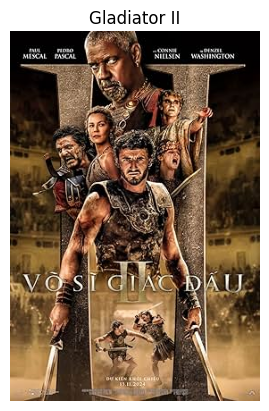

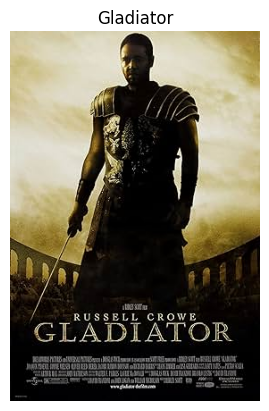

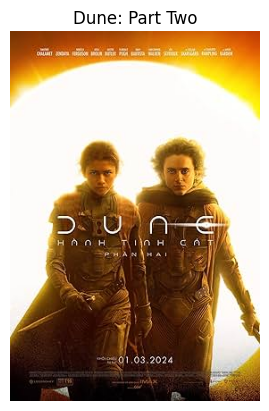

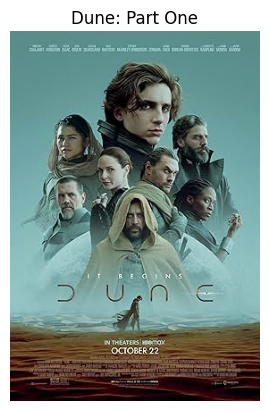

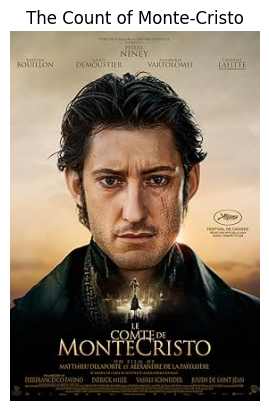

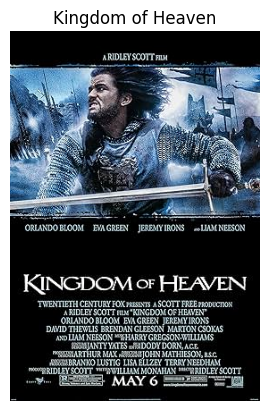

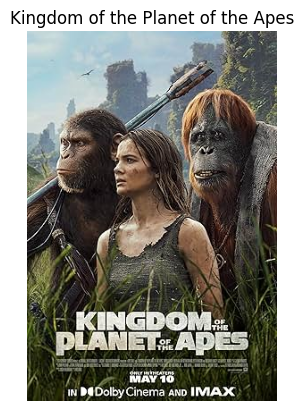

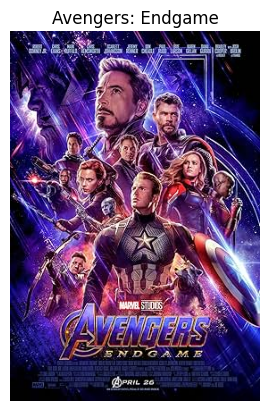

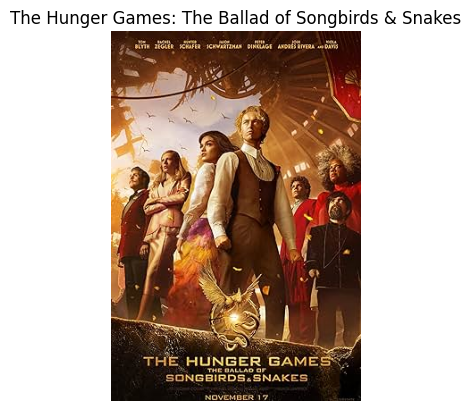

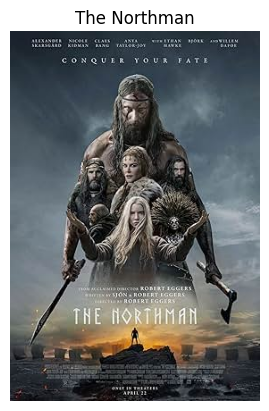

In [15]:
recommend_movies_content('nicknocks')

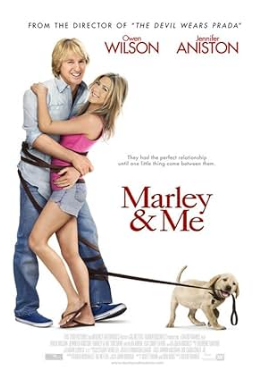

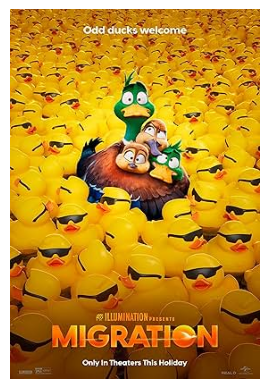

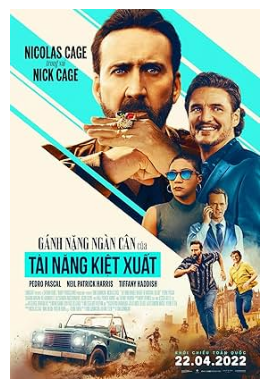

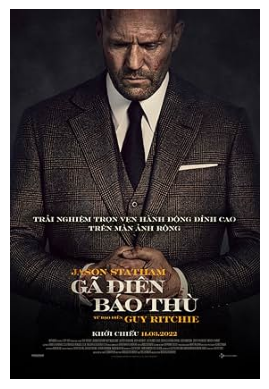

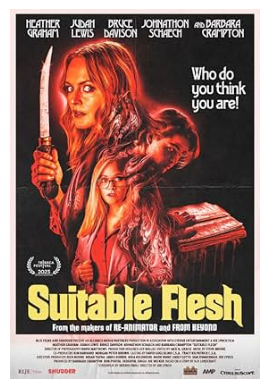

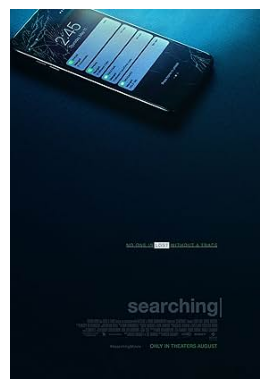

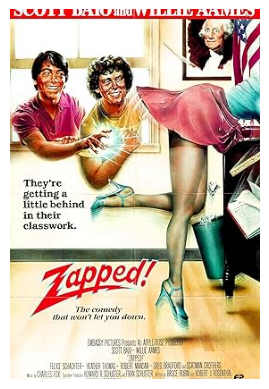

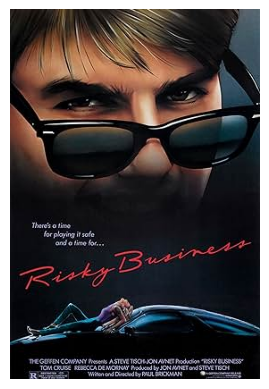

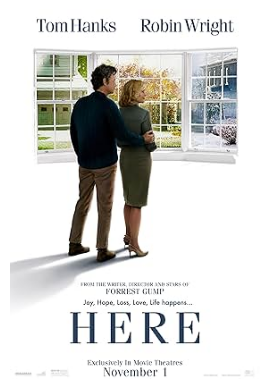

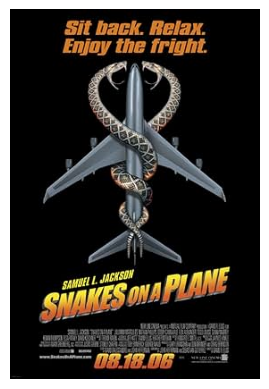

In [14]:
recommend_movies_collab('bolehornot')

In [ ]:
# Lọc những reviewer có số lượng đánh giá trên 2 lần
reviewer_counts = reviews_df['Reviewer'].value_counts()
filtered_reviewers = reviewer_counts[reviewer_counts >= 2]

# Sắp xếp từ bé đến lớn
sorted_reviewers = filtered_reviewers.sort_values()
sorted_reviewers.head(100)

Reviewer
bolehornot         2
Movies_Frever      2
redryan64          2
AgentPhoenixxx     2
Bryan_Roderick     2
                  ..
Smalling-2         2
jamesbond-28264    2
michroberto        2
LoupGarouTFTs      2
Rebochan           2
Name: count, Length: 100, dtype: int64